# Getting Started
Minecraft bedrock's data is stored in a LevelDB database. Let's get a LevelDB library and start looking at a world.

In [1]:
from leveldb import LevelDB
db_filename = "jupyter-world/db"
db = LevelDB(db_filename)

The file opened without errors. LevelDB is a "key/value" datastore. It's like a big python dictionary. Let's see how many keys there are.

In [2]:
num_keys = 0

# This library doesn't provide a way to quickly find the number of keys, so we have to iterate the entire list of keys.
for i in db.keys():
    # In case there's a lot of keys, let's print some progress
    if num_keys % 10000 == 0:
        print(f"processed {num_keys} keys")
    num_keys += 1
print(f"Number of Keys - {num_keys}")

processed 0 keys
Number of Keys - 442


Large world files can have hundreds of thousands or millions of keys so I'm not going to print all of them. Let's first see if there's anything that's ascii readable.

In [3]:
import string
strs = set()
for i in db.keys():
    strs.add(''.join(filter(lambda x: bytes(x, "latin-1") < b'\x80' and str(x) in string.printable, i.decode("latin-1"))))

print(sorted(strs, key=len, reverse=True)[0:500])

['LevelChunkMetaDataDictionary', 'AutonomousEntities', 'map_-4294967241', 'map_-4294967239', 'map_-4294967240', 'map_-4294967238', 'map_-4294967242', '~local_player', 'actorprefix1', 'actorprefix=', 'actorprefix@', 'actorprefix;', 'actorprefix<', 'actorprefix?', 'actorprefix>', 'schedulerWT', 'actorprefix', 'scoreboard', 'Overworld', 'mobevents', 'BiomeData', 'digp', '6', '@', ',', '/', '+', '1', 'A', '?']


There do seem to be some patterns here. I see 'LevelChunkMetaDataDictionary', 'AutonomousEntities', 'BiomeData', 'Overworld', 'mobevents', 'schedulerWT', 'scoreboard', and a bunch that start with 'actorprefix', 'digp', and 'map_'. (VILLAGE, player, player_server)

How many keys are there in total, and how many are there that start with those strings?

In [4]:
total = 0
actorprefix = 0
village = 0
player_server = 0
player = 0
digp = 0
map = 0
for i in db.keys():
    if i.startswith(b"actorprefix"): actorprefix += 1
    elif i.startswith(b"digp"): digp += 1
    elif i.startswith(b"player_server"): player_server += 1
    elif i.startswith(b"player"): player += 1
    elif i.startswith(b"VILLAGE_"): village += 1
    elif i.startswith(b"map_"): map += 1
    total += 1

print(f"actorprefix- {actorprefix} ({round((actorprefix*100)/total)}%)")
print(f"digp- {digp} ({round((digp*100)/total)}%)")
print(f"map- {map} ({round((map*100)/total)}%)")
print(f"village- {village} ({round((village*100)/total)}%)")
print(f"player_server- {player_server} ({round((player_server*100)/total)}%)")
print(f"player- {player} ({round((player*100)/total)}%)")
print(f"total- {total}")

actorprefix- 8 (2%)
digp- 28 (6%)
map- 5 (1%)
village- 0 (0%)
player_server- 0 (0%)
player- 0 (0%)
total- 442


# Diving In
## actorprefix

Let's start with looking at actorprefix records

In [6]:
iterator = db.new_iterator()
iterator.seek(b'actorprefix') # seek to the given key, or to the first one that is after where that key would be.

# This will print the key and the value of the key that is "actorprefix" or the first one that is lexicographically after it.
print(f"key - {iterator.key()}")
print(f"value - {iterator.value()}")

key - b'actorprefix\x00\x00\x00\x01\x00\x00\x00\x07'
value - b'\n\x00\x00\x02\x03\x00Air,\x01\t\x05\x00Armor\n\x04\x00\x00\x00\x01\x05\x00Count\x00\x02\x06\x00Damage\x00\x00\x08\x04\x00Name\x00\x00\x01\x0b\x00WasPickedUp\x00\x00\x01\x05\x00Count\x00\x02\x06\x00Damage\x00\x00\x08\x04\x00Name\x00\x00\x01\x0b\x00WasPickedUp\x00\x00\x01\x05\x00Count\x00\x02\x06\x00Damage\x00\x00\x08\x04\x00Name\x00\x00\x01\x0b\x00WasPickedUp\x00\x00\x01\x05\x00Count\x00\x02\x06\x00Damage\x00\x00\x08\x04\x00Name\x00\x00\x01\x0b\x00WasPickedUp\x00\x00\x02\n\x00AttackTime\x00\x00\t\n\x00Attributes\n\x08\x00\x00\x00\x05\x04\x00Base\x00\x00\x80A\x05\x07\x00Current\x00\x00\x80A\x05\n\x00DefaultMax\x00\x00\x00E\x05\n\x00DefaultMin\x00\x00\x00\x00\x05\x03\x00Max\x00\x00\x00E\x05\x03\x00Min\x00\x00\x00\x00\x08\x04\x00Name\x16\x00minecraft:follow_range\x00\x05\x04\x00Base\x00\x00\x00\x00\x05\x07\x00Current\x00\x00\x00\x00\x05\n\x00DefaultMax\x00\x00\x80D\x05\n\x00DefaultMin\x00\x00\x80\xc4\x05\x03\x00Max\x00\x00\x80

Looks like we're getting somewhere. I see some text I recognize; "minecraft:chicken" among others.

I'm guessing this is in NBT format. Let's use amulet's nbt library

In [3]:
import amulet_nbt
from amulet_nbt import utf8_escape_decoder

data = db.get(b'actorprefix\x00\x00\x00\x01\x00\x00\x00\x07')
nbt = amulet_nbt.load(data, little_endian=True, string_decoder=utf8_escape_decoder)
print(nbt)

NamedTag(CompoundTag({'Air': ShortTag(300), 'Armor': ListTag([CompoundTag({'Count': ByteTag(0), 'Damage': ShortTag(0), 'Name': StringTag(""), 'WasPickedUp': ByteTag(0)}), CompoundTag({'Count': ByteTag(0), 'Damage': ShortTag(0), 'Name': StringTag(""), 'WasPickedUp': ByteTag(0)}), CompoundTag({'Count': ByteTag(0), 'Damage': ShortTag(0), 'Name': StringTag(""), 'WasPickedUp': ByteTag(0)}), CompoundTag({'Count': ByteTag(0), 'Damage': ShortTag(0), 'Name': StringTag(""), 'WasPickedUp': ByteTag(0)})], 10), 'AttackTime': ShortTag(0), 'Attributes': ListTag([CompoundTag({'Base': FloatTag(16.0), 'Current': FloatTag(16.0), 'DefaultMax': FloatTag(2048.0), 'DefaultMin': FloatTag(0.0), 'Max': FloatTag(2048.0), 'Min': FloatTag(0.0), 'Name': StringTag("minecraft:follow_range")}), CompoundTag({'Base': FloatTag(0.0), 'Current': FloatTag(0.0), 'DefaultMax': FloatTag(1024.0), 'DefaultMin': FloatTag(-1024.0), 'Max': FloatTag(1024.0), 'Min': FloatTag(-1024.0), 'Name': StringTag("minecraft:luck")}), CompoundTa

In [55]:
# Looks like it parses well. Let's pretty-print it.

def print_nbt(nbt):
    print(nbt.to_snbt(indent=4))

print_nbt(nbt)

{
    "Air": 300s,
    "Armor": [
        {
            "Count": 0b,
            "Damage": 0s,
            "Name": "",
            "WasPickedUp": 0b
        },
        {
            "Count": 0b,
            "Damage": 0s,
            "Name": "",
            "WasPickedUp": 0b
        },
        {
            "Count": 0b,
            "Damage": 0s,
            "Name": "",
            "WasPickedUp": 0b
        },
        {
            "Count": 0b,
            "Damage": 0s,
            "Name": "",
            "WasPickedUp": 0b
        }
    ],
    "AttackTime": 0s,
    "Attributes": [
        {
            "Base": 16.0f,
            "Current": 16.0f,
            "DefaultMax": 2048.0f,
            "DefaultMin": 0.0f,
            "Max": 2048.0f,
            "Min": 0.0f,
            "Name": "minecraft:follow_range"
        },
        {
            "Base": 0.0f,
            "Current": 0.0f,
            "DefaultMax": 1024.0f,
            "DefaultMin": -1024.0f,
            "Max": 1024.0f,
       

There's some interesting stuff in there. "Pos" is probably this chicken's (x, y, z) coordinates.

Let's see how many different types we have.

In [9]:
identifiers = {}
for (k, v) in db.iterate(start = b'actorprefix', end = b'actorprefiz'):
    nbt = amulet_nbt.load(v, little_endian=True, string_decoder=utf8_escape_decoder).compound
    id = str(nbt['identifier'])
    if id in identifiers:
        identifiers[id] += 1
    else:
        identifiers[id] = 1

print(dict(sorted(identifiers.items(), key=lambda x:x[1], reverse=True)))

{'minecraft:chicken': 3, 'minecraft:drowned': 2, 'minecraft:pig': 2, 'minecraft:donkey': 1}


I wonder what 'minecraft:item' ids are. Maybe a dropped item?

In [15]:
for (k, v) in db.iterate(start = b'actorprefix', end = b'actorprefiz'):
    nbt = amulet_nbt.load(v, little_endian=True, string_decoder=utf8_escape_decoder).compound
    id = str(nbt['identifier'])
    if id == 'minecraft:item':
        print(nbt.to_snbt(indent=4))
        break

Looks like maybe.

Let's do the same loop, but demux the "minecraft:item"s

In [14]:
identifiers = {}
for (k, v) in db.iterate(start = b'actorprefix', end = b'actorprefiz'):
    nbt = amulet_nbt.load(v, little_endian=True, string_decoder=utf8_escape_decoder).compound
    id = str(nbt['identifier'])
    if id == 'minecraft:item':
        Item = nbt['Item']
        if 'Block' in Item:
            id = f"minecraft:item : {str(nbt['Item']['Block']['name'])}"
        else:
            id = f"minecraft:item : {str(nbt['Item']['Name'])}"
    if id in identifiers:
        identifiers[id] += 1
    else:
        identifiers[id] = 1

print(dict(sorted(identifiers.items(), key=lambda x:x[1], reverse=True)))

{'minecraft:chicken': 3, 'minecraft:drowned': 2, 'minecraft:pig': 2, 'minecraft:donkey': 1}


Ooo, some netherite and diamond gear!

In [18]:
for (k, v) in db.iterate(start = b'actorprefix', end = b'actorprefiz'):
    nbt = amulet_nbt.load(v, little_endian=True, string_decoder=utf8_escape_decoder).compound
    id = str(nbt['identifier'])
    if id == 'minecraft:item':
        Item = nbt['Item']
        if 'Name' in Item and ('netherite' in str(Item['Name']) or 'diamond' in str(Item['Name'])):
            print(f"{Item['Name']} - ({nbt['Pos'][0]}, {nbt['Pos'][1]}, {nbt['Pos'][2]})")

minecraft:diamond - (148.875, -58.875, 54.05085372924805)
minecraft:diamond - (148.48281860351562, -57.33802795410156, 54.563507080078125)
minecraft:diamond - (109.875, -26.875, 50.64805603027344)
minecraft:diamond - (126.80826568603516, -7.875, 80.01520538330078)
minecraft:diamond_pickaxe - (16.875, 61.62867736816406, -19.125)
minecraft:diamond - (144.58200073242188, -36.56157684326172, -117.6743392944336)
minecraft:diamond_pickaxe - (144.771728515625, -43.875, -11.549333572387695)
minecraft:diamond - (147.8363037109375, -44.875, -13.616943359375)
minecraft:diamond - (145.125, -45.125, -15.485634803771973)
minecraft:diamond_sword - (-556.875, 54.125, 276.875)
minecraft:diamond_sword - (-556.875, 54.125, 276.125)
minecraft:diamond_sword - (-555.125, 55.125, 275.8299255371094)
minecraft:diamond_sword - (-556.125, 55.125, 273.13507080078125)
minecraft:diamond_sword - (-556.119384765625, 46.125, 276.125)
minecraft:diamond_sword - (-566.6365356445312, 46.125, 273.841796875)
minecraft:diamo

## digp
[This URL](https://learn.microsoft.com/en-us/minecraft/creator/documents/actorstorage) describes a relationship between the 'digp' keys and the 'actorprefix' keys.

Let's look at the 'digp' keys and values.

In [13]:
iterator = db.new_iterator()
iterator.seek(b"digp")
number_to_print = 20
while number_to_print >= 0 and iterator.key().startswith(b"digp"):
    print(f"Key - {iterator.key()}")
    print(f"Value - {iterator.value()}")
    iterator.next()
    number_to_print -= 1

Key - b'digp\x00\x00\x00\x00\x00\x00\x00\x00'
Value - b'\x00\x00\x00\x01\x00\x00\x00@'
Key - b'digp\x00\x00\x00\x00\xfb\xff\xff\xff'
Value - b'\x00\x00\x00\x01\x00\x00\x00>'
Key - b'digp\x00\x00\x00\x00\xfc\xff\xff\xff'
Value - b''
Key - b'digp\x00\x00\x00\x00\xfe\xff\xff\xff'
Value - b''
Key - b'digp\x00\x00\x00\x00\xff\xff\xff\xff'
Value - b''
Key - b'digp\x01\x00\x00\x00\x00\x00\x00\x00'
Value - b''
Key - b'digp\x01\x00\x00\x00\xfb\xff\xff\xff'
Value - b''
Key - b'digp\x01\x00\x00\x00\xfc\xff\xff\xff'
Value - b''
Key - b'digp\x01\x00\x00\x00\xfd\xff\xff\xff'
Value - b'\x00\x00\x00\x01\x00\x00\x001'
Key - b'digp\x01\x00\x00\x00\xfe\xff\xff\xff'
Value - b''
Key - b'digp\x01\x00\x00\x00\xff\xff\xff\xff'
Value - b''
Key - b'digp\x02\x00\x00\x00\xfe\xff\xff\xff'
Value - b''
Key - b'digp\x02\x00\x00\x00\xff\xff\xff\xff'
Value - b'\x00\x00\x00\x01\x00\x00\x00=\x00\x00\x00\x01\x00\x00\x00<'
Key - b'digp\x03\x00\x00\x00\xfc\xff\xff\xff'
Value - b''
Key - b'digp\x03\x00\x00\x00\xfe\xff\xff\xf

So, the digp keys have the form digp(4-byte x chunk ID)+(4-byte z chunk-id)+(optional 4-byte dimension ID)
If the dimension ID is missing, then it's the Overworld.

    b'digp\x00\x00\x00\x00\x00\x00\x00\x00' is (0, 0) Overworld
    b'digp\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00' is (0, 0) Nether
    b'digp\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00' is (0, 0) The End

The values for each key are 8-byte values that are the actorprefix ids.
Let's see what the actors are at (0, 0) in the Overworld.

In [9]:
digp = db[b"digp\x00\x00\x00\x00\x00\x00\x00\x00"]
for i in range(0, len(digp) // 8 * 8, 8):
    v = db[b"actorprefix" + digp[i : i + 8]]
    nbt = amulet_nbt.load(v, little_endian=True, string_decoder=utf8_escape_decoder).compound
    print(nbt['identifier'])
    count += 1

0
minecraft:pig


I wonder if there are actorprefixes that aren't in the digp. Are there any digp ActorUniqueIDs in digp that don't exist in actorprefix?

In [13]:
digp = set()
iterator = db.new_iterator()
iterator.seek(b"digp")
count = 0
print("processing digp")
while iterator.key().startswith(b"digp"):
    if count % 10000 == 0 and count != 0:
        print(f"processed {count}")
    v = iterator.value()
    for i in range(0, len(v) // 8 * 8, 8):
        apfx = v[i : i + 8]
        digp.add(v[i : i + 8])
    iterator.next()
    count += 1
print(f"size of digp - {len(digp)}")

actorprefix = set()
iterator = db.new_iterator()
iterator.seek(b"actorprefix")
count = 0
print("processing actorprefix")
while iterator.key().startswith(b"actorprefix"):
    if count % 10000 == 0 and count != 0:
        print(f"processed {count}")
    actorprefix.add(iterator.key()[11:])
    iterator.next()
    count += 1
print(f"size of actorprefix - {len(actorprefix)}")

print(f"Number of actors that are in digp but not actorprefix - {len(digp.difference(actorprefix))}")
print(f"Number of actors in actorprefix but not in digp - {len(actorprefix.difference(digp))}")

processing digp
size of digp - 8
processing actorprefix
size of actorprefix - 8
Number of actors that are in digp but not actorprefix - 0
Number of actors in actorprefix but not in digp - 0


It looks like we're good. In older worlds, there are can be many disjoint records. There's a [Mojang bug report](https://bugs.mojang.com/browse/MCPE-155283) for this scenario.

In [13]:
identifiers = {}
iterator = db.new_iterator()
iterator.seek(b"digp")
while iterator.key().startswith(b"digp"):
    v = iterator.value()
    for i in range(0, len(iterator.value()) // 8 * 8, 8):
        try:
            data = db[b'actorprefix'+v[i : i + 8]]
        except:
            continue
        nbt = amulet_nbt.load(data, little_endian=True, string_decoder=utf8_escape_decoder).compound
        id = str(nbt['identifier'])
        if id == 'minecraft:item':
            Item = nbt['Item']
            if 'Block' in Item:
                id = f"minecraft:item : {str(nbt['Item']['Block']['name'])}"
            else:
                id = f"minecraft:item : {str(nbt['Item']['Name'])}"
        if id in identifiers:
            identifiers[id] += 1
        else:
            identifiers[id] = 1

    iterator.next()

print(dict(sorted(identifiers.items(), key=lambda x:x[1], reverse=True)))        

{'minecraft:chicken': 3, 'minecraft:pig': 2, 'minecraft:drowned': 2, 'minecraft:donkey': 1}


Any diamond or netherite gear there?

In [66]:
for k in identifiers.keys():
    if ('netherite' in k) or ('diamond' in k):
        print(k)

minecraft:item : minecraft:diamond_chestplate
minecraft:item : minecraft:netherite_pickaxe
minecraft:item : minecraft:netherite_chestplate
minecraft:item : minecraft:netherite_sword
minecraft:item : minecraft:diamond_helmet
minecraft:item : minecraft:netherite_boots


In [75]:
# Let's do the earlier one but print xyz and dimension for netherite gear.

iterator = db.new_iterator()
iterator.seek(b"digp")
while iterator.key().startswith(b"digp"):
    if len(iterator.key()) == 12:
        dimension = 'Overworld'
    elif int.from_bytes(iterator.key()[12:], "little") == 1:
        dimension = 'Nether'
    elif int.from_bytes(iterator.key()[12:], "little") == 2:
        dimension = 'The End'
    else:
        print(f"Error - {iterator.key()}")
        print(iterator.key()[12:])
        break
    v = iterator.value()
    for i in range(0, len(iterator.value()) // 8 * 8, 8):
        try:
            data = db[b'actorprefix'+v[i : i + 8]]
        except:
            continue
        nbt = amulet_nbt.load(data, little_endian=True, string_decoder=utf8_escape_decoder).compound
        if str(nbt['identifier']) == 'minecraft:item':
            if 'Name' in nbt['Item'] and 'netherite' in str(nbt['Item']['Name']):
                print(f"item - {str(nbt['Item']['Name'])} : ({nbt['Pos'][0]}, {nbt['Pos'][1]}, {nbt['Pos'][2]}) {dimension}")
    iterator.next()

item - minecraft:netherite_pickaxe : (-2755.374755859375, 61.125, 958.3462524414062) The End
item - minecraft:netherite_chestplate : (-2754.31591796875, 60.125, 959.125) The End
item - minecraft:netherite_sword : (-2752.7783203125, 60.125, 961.5545043945312) The End
item - minecraft:netherite_pickaxe : (-2749.971435546875, 59.125, 963.91455078125) The End
item - minecraft:netherite_boots : (-2751.718017578125, 60.125, 962.5758056640625) The End


Looks like somebody died in the end with a full kit of netherite gear and it's still lying on the ground. I'll have to fly out there and look for it.

## ~local_player, player, and player_server
Another key that's always around is ~local_player. If you've had remote players join the world, then there'd also be player and player_server records. Let's look at some of these.

In [99]:
print(db[b"~local_player"])

b'\n\x00\x00\x02\x03\x00Air,\x01\t\x05\x00Armor\n\x04\x00\x00\x00\x01\x05\x00Count\x00\x02\x06\x00Damage\x00\x00\x08\x04\x00Name\x00\x00\x01\x0b\x00WasPickedUp\x00\x00\x01\x05\x00Count\x00\x02\x06\x00Damage\x00\x00\x08\x04\x00Name\x00\x00\x01\x0b\x00WasPickedUp\x00\x00\x01\x05\x00Count\x00\x02\x06\x00Damage\x00\x00\x08\x04\x00Name\x00\x00\x01\x0b\x00WasPickedUp\x00\x00\x01\x05\x00Count\x00\x02\x06\x00Damage\x00\x00\x08\x04\x00Name\x00\x00\x01\x0b\x00WasPickedUp\x00\x00\x02\n\x00AttackTime\x00\x00\t\n\x00Attributes\n\x0e\x00\x00\x00\x05\x04\x00Base\x00\x00\x00\x00\x05\x07\x00Current\x00\x00\x00\x00\x05\n\x00DefaultMax\x00\x00\x80?\x05\n\x00DefaultMin\x00\x00\x00\x00\x05\x03\x00Max\x00\x00\x80?\x05\x03\x00Min\x00\x00\x00\x00\x08\x04\x00Name\x1b\x00minecraft:player.experience\x00\x05\x04\x00Base\x00\x00\x00\x00\x05\x07\x00Current\x00\x00\x00\x00\x05\n\x00DefaultMax\x00\xae\xc1F\x05\n\x00DefaultMin\x00\x00\x00\x00\x05\x03\x00Max\x00\xae\xc1F\x05\x03\x00Min\x00\x00\x00\x00\x08\x04\x00Name\x

Looks like more NBT

In [100]:
nbt = amulet_nbt.load(db[b"~local_player"], little_endian=True, string_decoder=utf8_escape_decoder).compound
print_nbt(nbt)

{
    "abilities": {
        "attackmobs": 1b,
        "attackplayers": 1b,
        "build": 1b,
        "doorsandswitches": 1b,
        "flying": 0b,
        "flySpeed": 0.05000000074505806f,
        "instabuild": 0b,
        "invulnerable": 0b,
        "lightning": 0b,
        "mayfly": 0b,
        "mine": 1b,
        "op": 1b,
        "opencontainers": 1b,
        "teleport": 1b,
        "walkSpeed": 0.10000000149011612f
    },
    "Air": 300s,
    "Armor": [
        {
            "Count": 0b,
            "Damage": 0s,
            "Name": "",
            "WasPickedUp": 0b
        },
        {
            "Count": 0b,
            "Damage": 0s,
            "Name": "",
            "WasPickedUp": 0b
        },
        {
            "Count": 0b,
            "Damage": 0s,
            "Name": "",
            "WasPickedUp": 0b
        },
        {
            "Count": 0b,
            "Damage": 0s,
            "Name": "",
            "WasPickedUp": 0b
        }
    ],
    "AttackTime": 0s,
 

Let's pretty-print some of the interesting bits from the NBT.

In [101]:
def display_armor(item):
    name = str(item['Name'])
    if name == "":
        print("    empty")
    else:
        short_name = name[10:]
        if "tag" in item and "display" in item["tag"]:
            print(f"    {short_name} ({item['tag']['display']['Name']})")
            # print enchantments?
        else:
            print(f"    {short_name}")
    pass
    
def display_item(item):
    name = str(item['Name'])
    if name == "":
        print("    empty")
    else:
        short_name = name[10:]
        if "tag" in item and "display" in item["tag"]:
            print(f"    {short_name} ({item['tag']['display']['Name']})")
        else:
            print(f"    {short_name}")
        

nbt = amulet_nbt.load(db[b"~local_player"], little_endian=True, string_decoder=utf8_escape_decoder).compound
print("Armor")
for i in nbt["Armor"]:
    display_armor(i)
    
print("EnderChestInventory")
for i in nbt["EnderChestInventory"]:
    display_item(i)
    
print("Inventory")
count = 0
for i in nbt["Inventory"]:
    display_item(i)

print(f"Mainhand - {str(nbt['Mainhand'][0]['Name'])[10:]}")
print(f"Offhand - {str(nbt['Offhand'][0]['Name'])[10:]}")
print(f"Pos - {nbt['Pos']}")

Armor
    empty
    empty
    empty
    empty
EnderChestInventory
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
Inventory
    empty
    filled_map
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
    empty
Mainhand - 
Offhand - 
Pos - [FloatTag(1.5609865188598633), FloatTag(73.62001037597656), FloatTag(-29.99022102355957)]


## map_

In [16]:
iterator = db.new_iterator()
iterator.seek(b"map_")
while iterator.key().startswith(b"map_"):
    nbt = amulet_nbt.load(iterator.value(), little_endian=True, string_decoder=utf8_escape_decoder).compound
    print(f"{iterator.key()} - ({nbt['xCenter']}, {nbt['zCenter']}) : scale - {nbt['scale']} : fullyExplored - {nbt['fullyExplored']} : decorations - {len(nbt['decorations'])}")
    iterator.next()

b'map_-4294967238' - (960, 960) : scale - 4 : fullyExplored - 0 : decorations - 0
b'map_-4294967239' - (448, 448) : scale - 3 : fullyExplored - 0 : decorations - 0
b'map_-4294967240' - (192, 192) : scale - 2 : fullyExplored - 0 : decorations - 0
b'map_-4294967241' - (64, 64) : scale - 1 : fullyExplored - 0 : decorations - 0
b'map_-4294967242' - (0, 0) : scale - 0 : fullyExplored - 0 : decorations - 0


b'map_-4294967238'


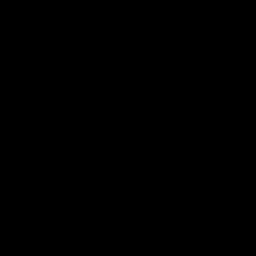

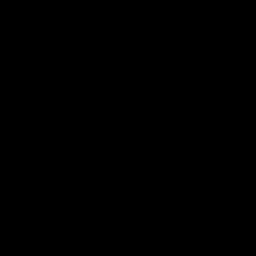

b'map_-4294967239'


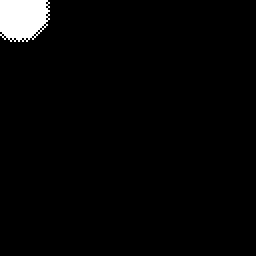

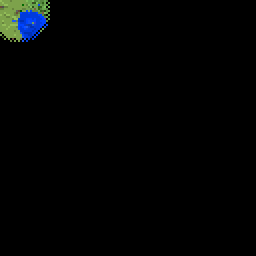

b'map_-4294967240'


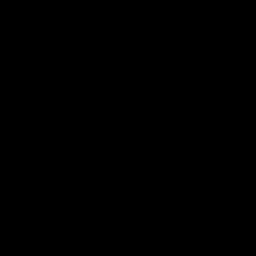

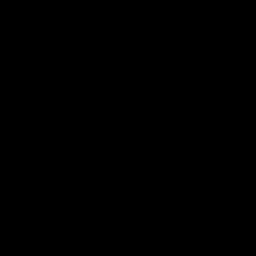

b'map_-4294967241'


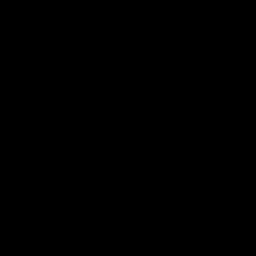

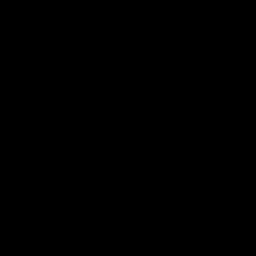

b'map_-4294967242'


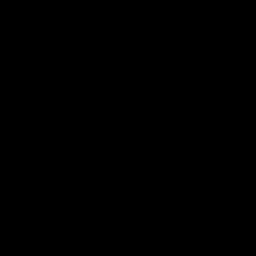

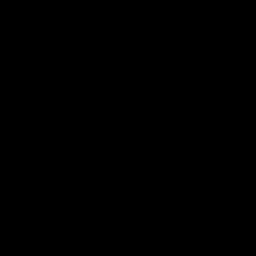

In [4]:
# Let's print some maps

def show_map(map_name):
    import numpy
    from PIL import Image

    # Let's get the entire NBT
    nbt = amulet_nbt.load(db[map_name], little_endian=True, string_decoder=utf8_escape_decoder).compound
    
    # Let's put the colors into a list
    colors = list(nbt['colors'])

    # There are four unsigned bytes per pixel of the map.
    # I have no idea what column 4 represents, so let's delete it and treat it as RGB
    del colors[4-1::4]

    # Reshape c as a 128x128 matrix of 8-bit unsi[R G B] values
    n_colors = numpy.array(colors).reshape(128, 128, -1).astype(numpy.uint8)
    Image.fromarray(n_colors).resize((256, 256), resample=Image.Resampling.NEAREST).show()

def show_alpha_map(map_name):
    import numpy
    from PIL import Image

    nbt = amulet_nbt.load(db[map_name], little_endian=True, string_decoder=utf8_escape_decoder).compound

    # Let's get the fourth value for each pixel, and interpret a 0 as black and a -1 (or 255 unsigned int) as white
    colors = list(map(lambda x: [0, 0, 0] if not x else [255, 255, 255], list(nbt['colors'])[3::4]))
    n_colors = numpy.array(colors).reshape(128, 128, -1).astype(numpy.uint8)
    Image.fromarray(n_colors).resize((256, 256), resample=Image.Resampling.NEAREST).show()

iterator = db.new_iterator()
iterator.seek(b"map_")
while iterator.key().startswith(b"map_"):
    print(iterator.key())
    show_alpha_map(iterator.key())
    show_map(iterator.key())
    iterator.next()

## BiomeData

In [57]:
nbt = amulet_nbt.load(db[b"BiomeData"], little_endian=True, string_decoder=utf8_escape_decoder).compound
print_nbt(nbt)

{
    "list": [
        {
            "id": 10b,
            "snowAccumulation": 0.125f
        },
        {
            "id": 11b,
            "snowAccumulation": 0.125f
        },
        {
            "id": 12b,
            "snowAccumulation": 0.25f
        },
        {
            "id": 13b,
            "snowAccumulation": 0.375f
        },
        {
            "id": 26b,
            "snowAccumulation": 0.125f
        },
        {
            "id": 30b,
            "snowAccumulation": 0.125f
        },
        {
            "id": 31b,
            "snowAccumulation": 0.125f
        },
        {
            "id": 46b,
            "snowAccumulation": 0.125f
        },
        {
            "id": 47b,
            "snowAccumulation": 0.125f
        },
        {
            "id": -116b,
            "snowAccumulation": 0.5f
        },
        {
            "id": -74b,
            "snowAccumulation": 0.125f
        },
        {
            "id": -73b,
            "snowAccumulation": 0.125

My guess is that the "id" is the binary biome id. 

In [43]:
# This data from https://minecraft.fandom.com/wiki/Biome
biome_name_to_id = {
    "ocean": 0,
    "legacy_frozen_ocean": 10,
    "deep_ocean": 24,
    "frozen_ocean": 46,
    "deep_frozen_ocean": 47,
    "cold_ocean": 44,
    "deep_cold_ocean": 45,
    "lukewarm_ocean": 42,
    "deep_lukewarm_ocean": 43,
    "warm_ocean": 40,
    "deep_warm_ocean": 41,
    "river": 7,
    "frozen_river": 11,
    "beach": 16,
    "stone_beach": 25,
    "cold_beach": 26,
    "forest": 4,
    "forest_hills": 18,
    "flower_forest": 132,
    "birch_forest": 27,
    "birch_forest_hills": 28,
    "birch_forest_mutated": 155,
    "birch_forest_hills_mutated": 156,
    "roofed_forest": 29,
    "roofed_forest_mutated": 157,
    "jungle": 21,
    "jungle_hills": 22,
    "jungle_mutated": 149,
    "jungle_edge": 23,
    "jungle_edge_mutated": 151,
    "bamboo_jungle": 48,
    "bamboo_jungle_hills": 49,
    "taiga": 5,
    "taiga_hills": 19,
    "taiga_mutated": 133,
    "cold_taiga": 30,
    "cold_taiga_hills": 31,
    "cold_taiga_mutated": 158,
    "mega_taiga": 32,
    "mega_taiga_hills": 33,
    "redwood_taiga_mutated": 160,
    "redwood_taiga_hills_mutated": 161,
    "mushroom_island": 14,
    "mushroom_island_shore": 15,
    "swampland": 6,
    "swampland_mutated": 134,
    "savanna": 35,
    "savanna_plateau": 36,
    "savanna_mutated": 163,
    "savanna_plateau_mutated": 164,
    "plains": 1,
    "sunflower_plains": 129,
    "desert": 2,
    "desert_hills": 17,
    "desert_mutated": 130,
    "ice_plains": 12,
    "ice_mountains": 13,
    "ice_plains_spikes": 140,
    "extreme_hills": 3,
    "extreme_hills_plus_trees": 34,
    "extreme_hills_mutated": 131,
    "extreme_hills_plus_trees_mutated": 162,
    "extreme_hills_edge": 20,
    "mesa": 37,
    "mesa_plateau": 39,
    "mesa_plateau_mutated": 167,
    "mesa_plateau_stone": 38,
    "mesa_plateau_stone_mutated": 166,
    "mesa_bryce": 165,
    "meadow": 186,
    "grove": 185,
    "snowy_slopes": 184,
    "jagged_peaks": 182,
    "frozen_peaks": 183,
    "stony_peaks": 189,
    "lush_caves": 187,
    "dripstone_caves": 188,
    "deep_dark": 190,
    "mangrove_swamp": 191,
    "hell": 8,
    "crimson_forest": 179,
    "warped_forest": 180,
    "soulsand_valley": 178,
    "basalt_deltas": 181,
    "the_end": 9,
    "cherry_grove": 192
}

biome_id_to_name = {v: k for k, v in biome_name_to_id.items()}

nbt = amulet_nbt.load(db[b"BiomeData"], little_endian=True, string_decoder=utf8_escape_decoder).compound["list"]
for i in nbt:
    # The Amulet NBT library doesn't seem to be able to return the ByteTag as a python "bytes" object
    # I'd like to convert the signed int to an unsigned int since the wiki's biome data is unsigned.
    bytes = int(i["id"]).to_bytes(1, byteorder="little", signed=True) # It's just a single byte, so "byte order" doesn't really matter
    uint = int.from_bytes(bytes, byteorder="little", signed=False)
    print(biome_id_to_name[uint])


legacy_frozen_ocean
frozen_river
ice_plains
ice_mountains
cold_beach
cold_taiga
cold_taiga_hills
frozen_ocean
deep_frozen_ocean
ice_plains_spikes
jagged_peaks
frozen_peaks
snowy_slopes
grove


Looks like a correct assumption.

## AutonomousEntities

In [58]:
nbt = amulet_nbt.load(db[b"AutonomousEntities"], little_endian=True, string_decoder=utf8_escape_decoder).compound
print_nbt(nbt)

{
    "AutonomousEntityList": []
}


Nothing exciting there.

## Overworld

In [47]:
nbt = amulet_nbt.load(db[b"Overworld"], little_endian=True, string_decoder=utf8_escape_decoder).compound
print_nbt(nbt)

{
    "data": {
        "LimboEntities": []
    }
}


In [ ]:
Nothing exciting there either.

## mobevents

In [49]:
nbt = amulet_nbt.load(db[b"mobevents"], little_endian=True, string_decoder=utf8_escape_decoder).compound
print_nbt(nbt)

{
    "events_enabled": 1b,
    "minecraft:ender_dragon_event": 1b,
    "minecraft:pillager_patrols_event": 1b,
    "minecraft:wandering_trader_event": 1b
}


## schedulerWT

In [51]:
nbt = amulet_nbt.load(db[b"schedulerWT"], little_endian=True, string_decoder=utf8_escape_decoder).compound
print_nbt(nbt)

{
    "daysSinceLastWTSpawn": 1,
    "isSpawningWT": 0b,
    "nextWTSpawnCheckTick": 24014L
}


## scoreboard

In [59]:
nbt = amulet_nbt.load(db[b"scoreboard"], little_endian=True, string_decoder=utf8_escape_decoder).compound
print_nbt(nbt)

{
    "Criteria": [],
    "DisplayObjectives": [],
    "Entries": [],
    "LastUniqueID": 0L,
    "Objectives": []
}


## VILLAGE

# Chunk Keys

Here we get to the meat of the data. Chunk keys. The Minecraft world is divided into chunks. Each chunk in the database is a box that is 16 blocks long in the x axis, 16 wide in the z axis, and spans from bedrock to the build limit in the y axis.

The format of these LevelDB keys for the _overworld_ is (chunk_x, chunk_z, chunk_tag). If the chunk_tag is 0x2F (or '/' in ASCII) then there's an additional byte for a subchunk id. Chunk keys for the nether and the end are slightly different and I'll cover those in a bit. As we saw above, the local_player is at (x, z) of (1, -29). Let's look at that chunk.

In [11]:
def x_z_to_chunk_x_chunk_z(x, z):
    return (x // 16, z // 16)

x = 1
z = -29
print(f"(x, z): ({x}, {z}) is (chunk_x, chunk_z): {x_z_to_chunk_x_chunk_z(x, z)}")

(x, z): (1, -29) is (chunk_x, chunk_z): (0, -2)


In [12]:
from struct import pack

x = 1
z = -29

(chunk_x, chunk_z) = x_z_to_chunk_x_chunk_z(1, -29)
chunk_key_x_z = pack("ii", chunk_x, chunk_z)

iterator = db.new_iterator()
iterator.seek(chunk_key_x_z)
while iterator.key().startswith(chunk_key_x_z):
    print(iterator.key())
    iterator.next()

LevelDBException: The database has been closed.

In [97]:
# Data from https://learn.microsoft.com/en-us/minecraft/creator/documents/actorstorage
LevelChunkTag_name_to_id = {
    "Data3D": 43,
    "Version": 44,
    "Data2D": 45,
    "Data2DLegacy": 46,
    "SubChunkPrefix": 47,
    "LegacyTerrain": 48,
    "BlockEntity": 49,
    "Entity": 50,
    "PendingTicks": 51,
    "LegacyBlockExtraData": 52,
    "BiomeState": 53,
    "FinalizedState": 54,
    "ConversionData": 55,
    "BorderBlocks": 56,
    "HardcodedSpawners": 57,
    "RandomTicks": 58,
    "CheckSums": 59,
    "GenerationSeed": 60,
    "GeneratedPreCavesAndCliffsBlending": 61,
    "BlendingBiomeHeight": 62,
    "MetaDataHash": 63,
    "BlendingData": 64,
    "ActorDigestVersion": 65,
    "LegacyVersion": 118
}

LevelChunkTag_id_to_name = {v: k for k, v in LevelChunkTag_name_to_id.items()}

iterator = db.new_iterator()
chunk_x = 0
chunk_z = -2
chunk_key_x_z = pack("ii", chunk_x, chunk_z)
iterator.seek(chunk_key_x_z)
while iterator.key().startswith(chunk_key_x_z):
    chunk_x = int.from_bytes(iterator.key()[0:3], byteorder="little", signed = True)
    chunk_z = int.from_bytes(iterator.key()[4:7], byteorder="little", signed = True)
    LevelChunkTag_name = LevelChunkTag_id_to_name[int.from_bytes(iterator.key()[8:9], byteorder="little")]
    print(f"chunk ({chunk_x}, {chunk_z}) : {LevelChunkTag_name}")
    iterator.next()

chunk (0, -2) : Data3D
chunk (0, -2) : Version
chunk (0, -2) : SubChunkPrefix
chunk (0, -2) : SubChunkPrefix
chunk (0, -2) : SubChunkPrefix
chunk (0, -2) : SubChunkPrefix
chunk (0, -2) : SubChunkPrefix
chunk (0, -2) : SubChunkPrefix
chunk (0, -2) : SubChunkPrefix
chunk (0, -2) : SubChunkPrefix
chunk (0, -2) : SubChunkPrefix
chunk (0, -2) : BlockEntity
chunk (0, -2) : FinalizedState
chunk (0, -2) : MetaDataHash
chunk (0, -2) : BlendingData
chunk (0, -2) : ActorDigestVersion


## BlockEntity

The BlockEntity keys contain data about blocks in the chunk that have variable states. Like the inventories of things like chests, hoppers, and furnaces or the text that's written on signs.

In [9]:
def print_items(items):
    if len(items) == 0:
        print("    Empty")
    else:
        for item in items:
            print(f"    Slot {item['Slot']} - {item['Name']} ({item['Count']})")
            
chunk_key = pack("iic", chunk_x, chunk_z, LevelChunkTag_name_to_id["BlockEntity"].to_bytes(1, "little"))
nbt = amulet_nbt.load(db[chunk_key], little_endian=True, string_decoder=utf8_escape_decoder).compound
print_items(nbt["Items"])

NameError: name 'pack' is not defined

In [2]:
db.close()